In [1]:
%load_ext autoreload
%autoreload 2


from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastai.vision.models.xresnet import *
from fastai.vision.models.unet import DynamicUnet
from bpho import *

/home/fredmonroe/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
img = open_image('cut.jpg')
img.shape, img.shape[1]/128

(torch.Size([3, 144, 256]), 1.125)

In [3]:
src = TileImageTileImageList(['cut_big.jpg'], tile_sz=256, num_tiles=10).split_none()

In [4]:
src.items

array([[0, 'cut_big.jpg', slice(1, 257, None), slice(216, 472, None)],
       [0, 'cut_big.jpg', slice(105, 361, None), slice(347, 603, None)],
       [0, 'cut_big.jpg', slice(107, 363, None), slice(721, 977, None)],
       [0, 'cut_big.jpg', slice(195, 451, None), slice(629, 885, None)],
       [0, 'cut_big.jpg', slice(157, 413, None), slice(329, 585, None)],
       [0, 'cut_big.jpg', slice(16, 272, None), slice(27, 283, None)],
       [0, 'cut_big.jpg', slice(156, 412, None), slice(646, 902, None)],
       [0, 'cut_big.jpg', slice(170, 426, None), slice(590, 846, None)],
       [0, 'cut_big.jpg', slice(239, 495, None), slice(210, 466, None)],
       [0, 'cut_big.jpg', slice(125, 381, None), slice(524, 780, None)]], dtype=object)

In [5]:
def scale_xy(xy):
    x,y = xy
    return (slice(x.start*4, x.stop*4), (y.start*4, y.stop*4))

def test_map(x):
    print(x)
    x[1] = x[1].replace('cut_big.jpg', 'cut_big3.jpg')
    return x

src.label_from_func(test_map, tile_scale=4) 

[0 'cut_big.jpg' slice(1, 257, None) slice(216, 472, None)]
[0 'cut_big.jpg' slice(105, 361, None) slice(347, 603, None)]
[0 'cut_big.jpg' slice(107, 363, None) slice(721, 977, None)]
[0 'cut_big.jpg' slice(195, 451, None) slice(629, 885, None)]
[0 'cut_big.jpg' slice(157, 413, None) slice(329, 585, None)]
[0 'cut_big.jpg' slice(16, 272, None) slice(27, 283, None)]
[0 'cut_big.jpg' slice(156, 412, None) slice(646, 902, None)]
[0 'cut_big.jpg' slice(170, 426, None) slice(590, 846, None)]
[0 'cut_big.jpg' slice(239, 495, None) slice(210, 466, None)]
[0 'cut_big.jpg' slice(125, 381, None) slice(524, 780, None)]


LabelLists;

Train: LabelList (10 items)
x: TileImageTileImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: TileImageList
Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024)
Path: .;

Valid: LabelList (0 items)
x: TileImageTileImageList

y: TileImageList

Path: .;

Test: None

[[(0, 'cut_big.jpg', slice(1, 257, None), slice(216, 472, None)), (0, 'cut_big.jpg', slice(105, 361, None), slice(347, 603, None)), (0, 'cut_big.jpg', slice(107, 363, None), slice(721, 977, None)), (0, 'cut_big.jpg', slice(195, 451, None), slice(629, 885, None)), (0, 'cut_big.jpg', slice(157, 413, None), slice(329, 585, None)), (0, 'cut_big.jpg', slice(16, 272, None), slice(27, 283, None)), (0, 'cut_big.jpg', slice(156, 412, None), slice(646, 902, None)), (0, 'cut_big.jpg', slice(170, 426, None), slice(590, 846, None)), (0, 'cut_big.jpg', slice(239, 495, None), slice(210, 466, None)), (0, 'cut_big.jpg', slice(125, 381, None), slice(524, 780, None))]]


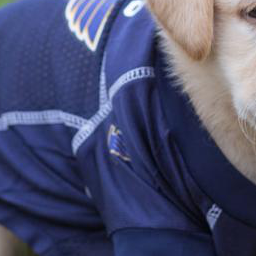

In [6]:
print(src.x.tile_infos)
src.x[4]

[[(0, 'cut_big.jpg', slice(1, 257, None), slice(216, 472, None)), (0, 'cut_big.jpg', slice(105, 361, None), slice(347, 603, None)), (0, 'cut_big.jpg', slice(107, 363, None), slice(721, 977, None)), (0, 'cut_big.jpg', slice(195, 451, None), slice(629, 885, None)), (0, 'cut_big.jpg', slice(157, 413, None), slice(329, 585, None)), (0, 'cut_big.jpg', slice(16, 272, None), slice(27, 283, None)), (0, 'cut_big.jpg', slice(156, 412, None), slice(646, 902, None)), (0, 'cut_big.jpg', slice(170, 426, None), slice(590, 846, None)), (0, 'cut_big.jpg', slice(239, 495, None), slice(210, 466, None)), (0, 'cut_big.jpg', slice(125, 381, None), slice(524, 780, None))]]


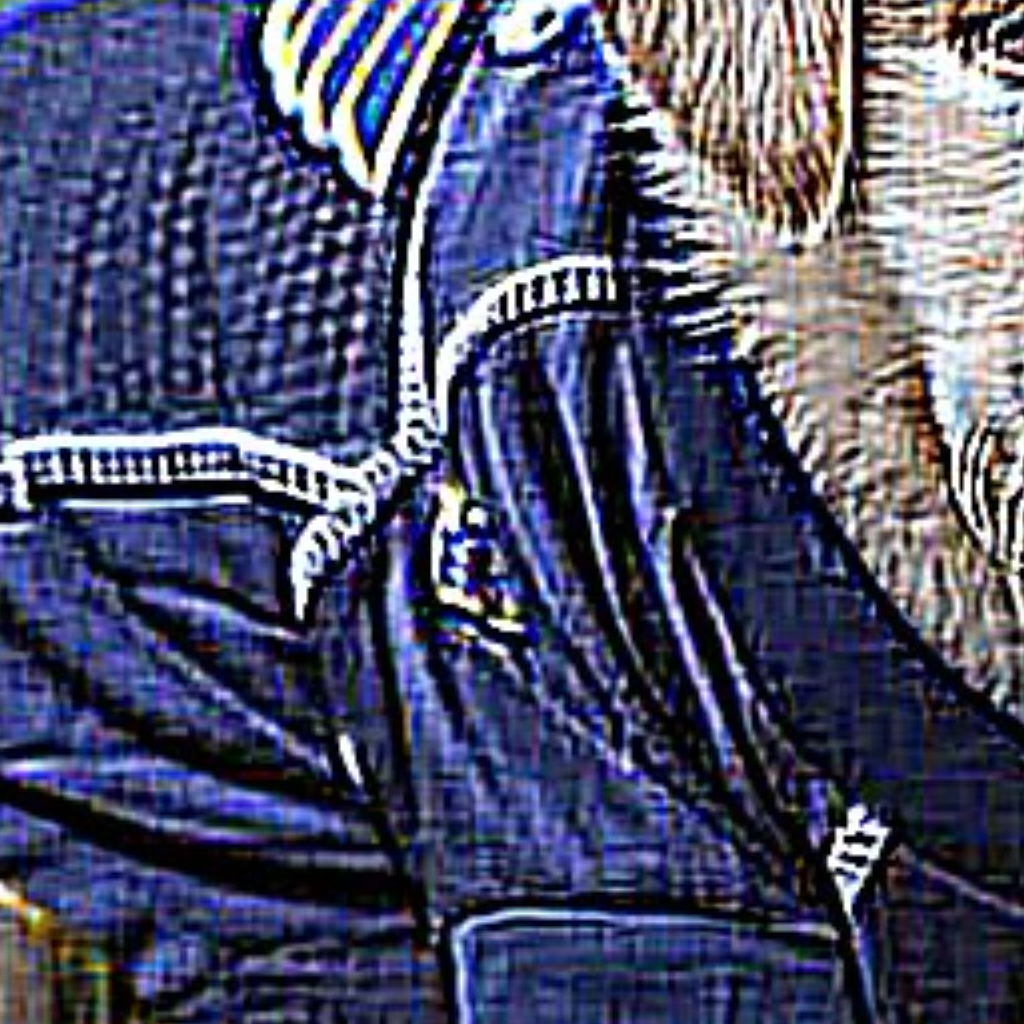

In [7]:
print(src.y.tile_infos)
src.y[4]

In [8]:
size = 128
bs = 9

tfms = get_transforms()
#zoomit = rand_zoom(scale=(2.0,4.0))
#tfms[0].insert(0,zoomit)
#tfms[1].insert(0,zoomit)
data = (src
        .transform(tfms, size=size)
        .transform_y(tfms, size=size)
        .databunch(bs=bs, num_workers=0))

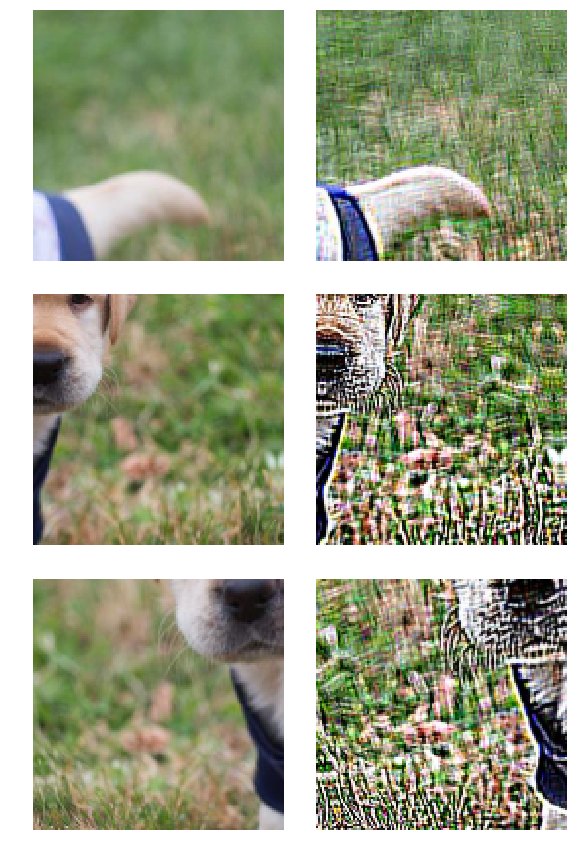

In [9]:
data.show_batch(3)
x,y = data.one_batch()

In [10]:
data_path = Path('.')

In [11]:
src = TileImageTileImageList.from_folder(data_path, 
                                         tile_sz=256, 
                                         num_tiles=5,
                                         #crap_func=simple_crap,
                                         img_list_cls=CziImageList, 
                                         extensions=['.tif','.czi']).split_none()

In [12]:
def test_map(x):
    x = x.copy()
    #print('MAP', x[0], x[1][0])
    return x[0],x[1][0]

src.label_from_func(test_map, tile_scale=1, num_tiles=5) 

LabelLists;

Train: LabelList (605 items)
x: TileImageTileImageList
Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256)
y: TileImageList
Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256)
Path: .;

Valid: LabelList (0 items)
x: TileImageTileImageList

y: TileImageList

Path: .;

Test: None

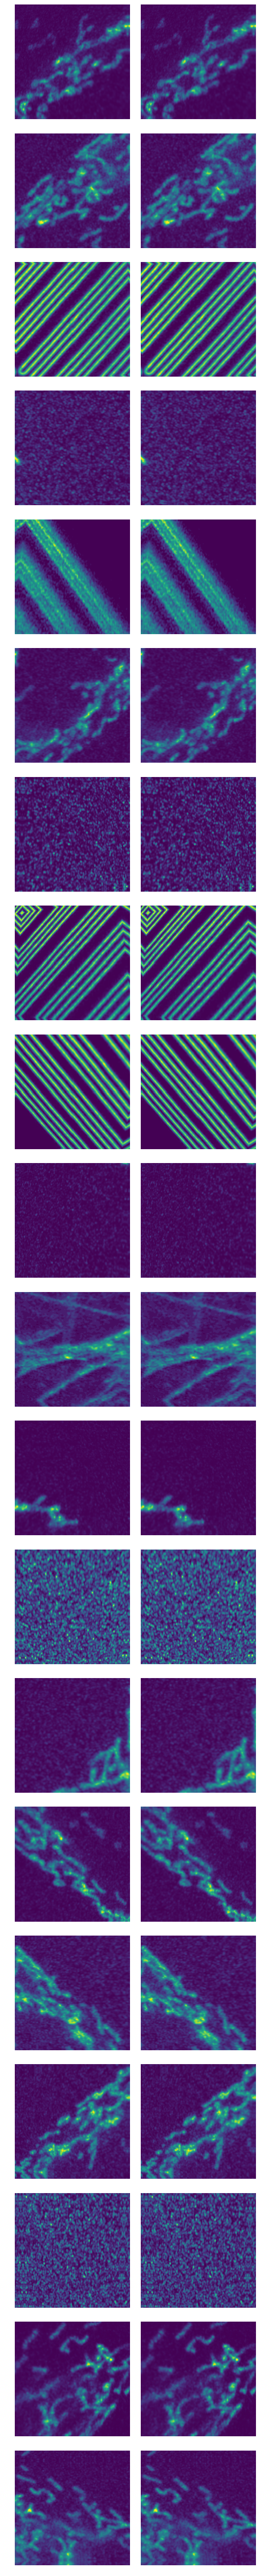

In [16]:
size = 256
bs = 20

tfms = get_transforms(flip_vert=True)
#tfms = [[],[]]
data = (src
        .transform(tfms, size=size)
        .transform_y(tfms, size=size)
        .databunch(bs=bs))

data.show_batch(20)